In [1]:
import raw_data
import ta

import math
import time
import datetime
from pytz import timezone

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

pd.set_option("display.max_columns", 60)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
prediction_period = 1  # Predict 1 day into the future
saved_models_root = "saved_models/"

daily_adjusted_df = raw_data.get_time_series_daily_adjusted("qqq")
EST = timezone("US/Eastern")
datetime_last_updated = datetime.datetime.now(EST)
print("Data retrieved on", datetime_last_updated.ctime())

# Remove most recent day if markets hadn't closed yet
latest_date = datetime.datetime.strptime(daily_adjusted_df.loc[0, "timestamp"], "%Y-%m-%d").date()
if latest_date == datetime_last_updated.date():
    closing_time = datetime.time(16, tzinfo=EST)
    if datetime_last_updated.timetz() < closing_time:
        daily_adjusted_df = daily_adjusted_df.iloc[1:].reset_index()

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

Data retrieved on Fri Sep  7 22:36:10 2018


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4.908000e+03,4908.000000,4908.000000
mean,70.290792,70.891823,69.586287,70.274720,62.636101,7.095016e+07,0.001927,1.000204
std,40.883203,41.169636,40.520261,40.900566,37.520546,5.355291e+07,0.022455,0.014274
min,19.940000,20.530000,19.760000,20.060000,17.833000,1.097837e+06,0.000000,1.000000
25%,38.980000,39.367500,38.610000,38.957500,34.953450,3.020612e+07,0.000000,1.000000
50%,53.140000,53.684350,52.617500,53.185000,47.439650,6.157919e+07,0.000000,1.000000
75%,100.892500,101.917500,99.533750,100.767500,83.740875,9.564513e+07,0.000000,1.000000
max,229.800000,232.900000,227.000000,230.000000,186.740000,6.165787e+08,0.386800,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-09-07,180.53,182.67,180.44,181.11,181.11,46406419,0.0,1.0
1,2018-09-06,183.54,183.75,180.58,181.81,181.81,46091403,0.0,1.0
2,2018-09-05,185.55,185.55,182.82,183.45,183.45,42623326,0.0,1.0
3,2018-09-04,186.10,186.40,184.85,185.85,185.85,29063537,0.0,1.0
4,2018-08-31,186.18,187.18,185.98,186.65,186.65,28653248,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, selected_features=None):
    base_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days, since we don't have their target values
    processed_df = base_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    
    if selected_features is None:
        # Drop features with very low variance
        original_num_features = processed_df.shape[1]
        processed_df = processed_df.loc[:, processed_df.std() > 0.01]
        print("Dropped {} features.".format(original_num_features - processed_df.shape[1]))
    else:
        processed_df = processed_df.loc[:, selected_features]
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df

In [4]:
def preprocess_features(df, means=None, stds=None):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()

    # Normalize features
    calculated_stats = False
    if means is None:
        means = processed_features.mean()
        calculated_stats = True
    if stds is None:
        stds = processed_features.std()
        calculated_stats = True
    processed_features = (processed_features - means) / stds
    
    if calculated_stats:
        return processed_features, means, stds
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

Dropped 2 features.


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,4907.000000,4907.000000,4907.000000,4907.000000,4.907000e+03,4.907000e+03,4.907000e+03,4.907000e+03,4907.000000,4.907000e+03,4.907000e+03,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4.907000e+03,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,70.268327,70.869044,69.563696,62.611958,7.095516e+07,-1.478426e+09,-4.588354e+06,-4.599167e+06,-10.989146,-7.723012e+06,1.414014e+04,5012.065468,8.155542,65.615555,60.133372,62.874463,0.029957,0.083147,67.773814,69.078201,66.469427,0.887304,65.064378,60.384176,0.083350,0.171184,-0.376132,-0.375042,-0.001090,62.945736,63.321868,34.579850,5.442398,7.947681,0.343998,0.255680,0.278514,0.076266,-0.026959,24.977880,-19.332355,0.040410,-3.182500,-3.128655,-0.053845,70.488924,70.599600,46.094684,4.507899e+01,-6.538022,1.199146,-82.582398,-82.472384,-182.582398,-0.222718,-0.012859,-0.028283,-65.561874,0.043652
std,40.857060,41.142887,40.493467,37.486220,5.355723e+07,1.230545e+09,8.849079e+07,2.733162e+07,8.623321,4.380978e+07,2.710879e+06,5151.484066,16.568208,38.823809,36.876388,37.802302,0.170487,0.276132,39.034775,39.611571,38.491253,0.316253,38.558304,36.911552,0.276439,0.376708,1.456742,1.384267,0.430595,37.875804,38.293570,11.809979,4.460743,7.483202,0.475089,0.175902,0.207969,0.089908,0.252219,1.107303,85.859435,1.299204,63.430753,62.225280,18.554167,41.346047,41.555961,11.421070,1.370665e+01,14.565458,10.235558,110.104788,108.718382,110.104788,5.602417,1.756381,1.756754,20.618349,1.760007
min,19.940000,20.530000,19.760000,17.833000,1.097837e+06,-7.604498e+09,-6.165787e+08,-1.233392e+08,-55.484104,-7.789983e+08,-4.897548e+07,1000.000000,1.312442,20.218384,16.893306,18.910015,0.000000,0.000000,20.031173,20.969173,19.093173,0.000000,19.984400,17.833000,0.000000,0.000000,-6.202580,-5.774535,-2.266304,19.594940,20.505554,13.878777,0.000000,0.000000,0.000000,0.022321,0.030932,0.000000,-0.823801,19.913482,-252.397671,-13.006740,-182.263124,-170.475772,-106.755081,21.722500,22.985000,12.833623,1.136868e-13,-45.276122,-43.849066,-775.673171,-701.588651,-875.673171,-24.725588,-14.413752,-15.564557,-90.191409,-9.286561
25%,38.980000,39.365000,38.610000,34.952100,3.020299e+07,-2.423551e+09,-6.603955e+07,-1.648490e+07,-14.631649,-1.010744e+07,-6.258651e+05,2093.652201,3.798824,36.398656,33.527420,35.062193,0.000000,0.000000,37.643478,38.352788,37.022908,1.000000,35.997000,33.580500,0.000000,0.000000,-1.055806,-0.999379,-0.197244,35.006146,34.836075,25.391970,2.169109,3.387253,0.000000,0.130509,0.150297,0.022350,-0.163951,24.388185,-91.164148,-0.465320,-37.436919,-36.701934,-9.793732,38.943750,38.495000,38.037275,3.569687e+01,-16.805039,-2.816831,-125.826081,-125.215148,-225.826081,-1.692821,-0.791442,-0.794590,-80.775480,-0.661997
50%,53.1400

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,183.54,183.7500,180.58,181.81,46091403,0.000000e+00,0,0.0,0.0,0.00,0.000000,1000.000000,3.170000,187.455802,177.281198,182.3685,0.0,0.0,184.28283,186.00332,182.56234,0.0,186.74,179.23,0.0,0.0,0.000000,0.000000,0.000000,181.810000,181.810000,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,180.432475,178.34495,50.000000,50.0,0.000000,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,-0.385017
2,185.55,185.5500,182.82,183.45,42623326,-3.327433e+07,42623326,0.0,0.0,0.00,0.000000,1009.020406,3.464828,187.455802,177.281198,182.3685,0.0,0.0,184.28283,186.00332,182.56234,0.0,186.74,179.23,0.0,0.0,0.017328,0.009120,0.008208,182.662800,182.645472,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,180.432475,178.34495,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,0.902041,0.897997,0.902041,-0.893977
3,186.10,186.4000,184.85,185.85,29063537,-1.451322e+07,29063537,0.0,0.0,-68792578.64,764705.860733,1022.221000,3.281252,187.455802,177.281198,182.3685,0.0,0.0,184.28283,186.00332,182.56234,0.0,186.74,179.23,0.0,0.0,0.057074,0.026815,0.030259,183.811279,183.754205,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,180.432475,178.34495,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,1.308258,1.299775,2.222100,-1.291364
4,186.18,187.1800,185.98,186.65,28653248,1.178068e+07,28653248,0.0,0.0,-44704249.60,503565.402102,1026.621198,2.741857,187.455802,177.281198,182.3685,0.0,0.0,184.28283,186.00332,182.56234,0.0,186.74,179.23,0.0,0.0,0.088660,0.044799,0.043861,184.608298,184.519638,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,180.432475,178.34495,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,0.430455,0.429531,2.662120,-0.428610
5,186.41,187.5199,185.79,186.41,29315453,-4.959127e+06,-29315453,0.0,0.0,141072.96,85644.581167,1026.621198,2.510622,187.455802,177.281198,182.3685,0.0,0.0,184.28283,186.00332,182.56234,0.0,186.74,179.23,0.0,0.0,0.101729,0.058701,0.043028,185.028500,184.926772,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,180.432475,178.34495,94.558704,50.0,97.804089,50.0,50.0,50.0,-50.0,0.0,-0.128583,-0.128666,2.530114,0.128748


In [6]:
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_rows = len(df)
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

# Shuffle before splitting into training and validation sets
training_and_validation_df = df.tail(num_training + num_validation).sample(frac=1)

training_df = training_and_validation_df.head(num_training)
training_examples, feature_means, feature_stds = preprocess_features(training_df)
training_targets = preprocess_targets(training_df)

validation_df = training_and_validation_df.tail(num_validation)
validation_examples = preprocess_features(validation_df, feature_means, feature_stds)
validation_targets = preprocess_targets(validation_df)

testing_df = df.head(num_testing)
testing_examples = preprocess_features(testing_df, feature_means, feature_stds)
testing_targets = preprocess_targets(testing_df)

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03,4.170000e+03
mean,-3.404471e-15,4.259849e-15,1.521618e-15,2.128220e-15,-8.690091e-17,1.363152e-17,-1.022364e-17,1.422789e-16,-3.142916e-15,2.232161e-16,3.407879e-18,-3.804897e-15,1.691160e-16,2.823428e-15,-1.154249e-14,-1.122896e-15,-3.578273e-17,6.986152e-17,-2.019168e-15,2.598508e-15,-4.225770e-16,-8.093712e-17,5.166344e-15,1.286474e-15,-6.815758e-18,1.192758e-17,1.976570e-16,2.751862e-16,-1.192758e-17,-9.576140e-16,-3.104578e-15,1.022364e-15,-2.187858e-15,3.978699e-16,7.838121e-17,-6.522680e-15,3.279231e-15,-4.187431e-16,3.237485e-17,-2.353268e-14,-4.583597e-16,-1.533545e-17,-3.237485e-17,-7.838121e-17,-1.703939e-17,-8.741209e-16,5.861552e-16,5.154417e-15,-8.826406e-16,8.451539e-16,-1.661341e-17,2.264322e-15,-1.950159e-15,-5.657931e-15,6.645364e-17,8.519697e-18,4.259849e-17,3.314162e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.268652e+00,-1.258192e+00,-1.268972e+00,-1.309666e+00,-1.324145e+00,-4.987066e+00,-6.785399e+00,-4.241448e+00,-5.121367e+00,-1.565268e+01,-1.459939e+01,-7.722161e-01,-4.118772e-01,-1.279179e+00,-1.281332e+00,-1.270994e+00,-1.807806e-01,-2.974347e-01,-1.293818e+00,-1.279731e+00,-1.306843e+00,-3.748437e+00,-1.280119e+00,-1.258373e+00,-3.068850e-01,-4.498595e-01,-4.071540e+00,-3.954164e+00,-5.387897e+00,-1.248797e+00,-1.216226e+00,-1.720987e+00,-1.283172e+00,-1.172966e+00,-7.494418e-01,-1.483418e+00,-1.382846e+00,-9.440323e-01,-3.121032e+00,-4.420755e+00,-2.710879e+00,-1.075647e+01,-2.794380e+00,-2.652469e+00,-5.644068e+00,-1.221751e+00,-1.184023e+00,-2.958861e+00,-3.273602e+00,-2.763391e+00,-7.664272e+00,-6.274206e+00,-5.676480e+00,-6.274206e+00,-4.155421e+00,-8.093932e+00,-8.726057e+00,-1.309666e+00
25%,-7.509001e-01,-7.521577e-01,-7.507494e-01,-7.542594e-01,-7.665583e-01,-7.792985e-01,-7.125567e

Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,0.002008,0.000943,0.005239,0.050373,0.001219,0.001097,-0.063456,-0.060840,0.055743,-0.056400,-0.029074,-0.132236,-0.068006,0.048525,0.051033,0.049845,-0.029264,0.038569,0.020309,0.017293,0.023414,-0.020083,0.047561,0.049786,-0.008618,0.040961,-0.043488,-0.056130,0.034699,0.050690,0.052240,0.005625,0.059346,0.056184,-0.047873,0.065674,0.043687,0.039218,0.015916,-0.011182,-0.048339,0.016121,0.017606,0.011354,0.021862,0.023746,0.026341,-0.038222,-0.019172,-0.002254,0.013490,0.044368,0.055943,0.044368,-0.043848,-0.050068,-0.050505,0.050373
std,0.922552,0.922946,0.928782,1.005811,1.016648,1.023935,1.003712,0.960787,0.976964,1.148502,1.380347,0.881209,0.864204,0.994553,1.008324,1.001368,0.918739,1.057698,0.959305,0.954272,0.964335,1.035116,0.996442,1.008684,0.988052,1.035797,0.923519,0.921018,1.026966,1.004111,1.008798,0.992902,1.066717,0.995165,0.985630,1.060610,0.961008,0.991789,1.054678,1.015582,0.976294,1.071415,1.066948,1.034897,0.980057,0.977808,0.976529,1.017573,0.991259,1.028329,0.986240,0.993598,1.001539,0.993598,0.493846,1.027211,1.024236,1.005811
min,-1.241505,-1.244591,-1.259061,-1.301064,-1.313924,-3.678300,-5.435624,-3.035117,-5.153871,-18.500393,-18.469370,-0.772216,-0.412564,-1.236297,-1.276614,-1.234200,-0.180781,-0.297435,-1.288540,-1.274462,-1.301562,-3.748437,-1.242253,-1.258373,-0.306885,-0.449860,-3.241279,-3.341669,-4.036097,-1.230672,-1.214605,-1.696078,-1.283172,-1.204620,-0.749442,-1.456583,-1.366348,-0.944009,-2.927300,-4.440250,-1.927751,-6.386196,-2.708547,-2.558654,-3.403747,-1.216765,-1.184023,-2.702065,-2.394754,-2.632925,-5.270499,-5.265165,-4.884012,-5.265165,-2.631586,-5.125937,-5.363078,-1.301064
25%,-0.703393,-0.709965,-0.708343,-0.698577,-0.773756,-0.816434,-0.780403,-0.470512,-0.339390,-0.122624,-0.315459,-0.606256,-0.271485,-0.709832,-0.693505,-0.698505,-0.180781,-0.297435,-0.717879,-0.722676,-0.722637,0.266714,-0.707839,-0.693591,-0.306885,-0.449860,-0.521989,-0.548882,-0.453643,-0.699162,-0.722943,-0.726058,-0.699788,-0.556679,-0.749442,-0.713904,-0.572549,-0.633068,-0.533219,-0.587270,-0.881791,-0.387201,-0.537063,-0.517010,-0.527087,-0.731001,-0.746041,-0.784612,-0.698339,-0.722459,-0.471064,-0.344112,-0.322199,-0.344112,-0.252668,-0.516047,-0.509222,-0.698577
50%,-0.367344,-0.362500,-0.363073,-0.343018,-0.162367,0.318052,-0.177813,-0.045464,0.202285,0.126303,-0.049825,-0.379699,-0.245590,-0.324611,-0.365566,-0.345877,-0.180781,-0.297435,-0.348047,-0.352640,-0.367772,0.266714,-0.323036,-0.366631,-0.306885,-0.449860,-0.134974,-0.166757,-0.021130,-0.352121,-0.374654,-0.132773,-0.226453,-0.2

Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,2.774662,2.762263,2.798278,3.567338,-0.665890,1.249732,-0.022772,-0.069359,1.298797,-0.227627,-0.036868,-0.781802,-0.343229,3.587405,3.561158,3.581575,-0.134537,0.058067,3.115819,3.078634,3.150568,-3.650903,3.595773,3.575312,-0.176999,0.069443,-0.921081,-0.885667,-0.260607,3.589180,3.596523,0.528700,2.246542,3.763640,-0.555437,3.409151,4.106610,2.499246,-0.223488,-0.274009,-0.315480,0.145642,-0.234945,-0.224224,-0.048145,2.896548,2.923723,-0.351506,-0.319555,-0.067368,6.258853,1.136782,1.152835,1.136782,-0.321632,-0.049566,-0.043727,3.567338
std,0.310401,0.310373,0.313359,0.381016,0.323534,0.042543,0.445260,0.361586,0.067405,1.536448,0.288051,0.022530,0.056747,0.365214,0.362084,0.356986,0.512856,1.085851,0.334651,0.334353,0.337087,0.619398,0.362771,0.367017,0.669285,1.059515,0.841506,0.774926,1.316133,0.354160,0.326128,0.814739,1.529740,1.500499,0.606673,1.027681,0.959135,2.667136,0.367746,1.412827,0.805836,1.915405,0.364395,0.355621,0.590199,0.262068,0.214841,1.079403,0.738154,1.555775,3.059150,0.262091,0.247867,0.262091,0.542027,0.589425,0.587542,0.381016
min,2.189652,2.163579,2.195474,2.832578,-1.191429,1.090066,-1.217429,-1.002931,1.150781,-15.650047,-1.360831,-0.814429,-0.422417,2.833615,2.945323,2.898030,-0.180781,-0.297435,2.485007,2.435809,2.532919,-3.748437,2.855707,2.952106,-0.306885,-0.449860,-2.318223,-2.180774,-2.386158,2.917869,2.971392,-1.349308,-1.283172,-0.870248,-0.749442,0.979279,1.754813,-0.944032,-0.820098,-4.715392,-2.205809,-8.723563,-0.834313,-0.766544,-1.928086,2.396158,2.473760,-2.409686,-2.209771,-1.668999,-1.372024,0.660902,0.688153,0.660902,-1.341178,-2.012058,-2.038865,2.832578
25%,2.536686,2.516804,2.550089,3.268656,-0.876768,1.221626,-0.332414,-0.339337,1.221688,-0.162070,-0.124608,-0.804336,-0.383572,3.304858,3.299179,3.321264,-0.180781,-0.297435,2.866156,2.803344,2.890328,-3.748437,3.335990,3.321964,-0.306885,-0.449860,-1.739799,-1.583399,-0.951536,3.344876,3.380123,-0.148651,1.204805,2.685493,-0.749442,2.729119,3.408057,0.323020,-0.519566,-0.895754,-0.951258,-0.795772,-0.510741,-0.508509,-0.324752,2.689230,2.728887,-1.061646,-0.779939,-0.872385,3.673662,0.933068,0.968144,0.933068,-0.709491,-0.377978,-0.370128,3.268656
50%,2.784648,2.785363,2.802333,3.574422,-0.758094,1.251926,-0.193734,-0.065173,1.319189,0.113733,-0.042208,-0.769710,-0.358764,3.633417,3.466828,3.550460,-0.180781,-0.297435,3.111495,3.097595,3.135034,-3.748437,3.607127,3.479770,-0.306885,-0.449860,-0.957819,-0.715663,-0.345412,3.557835,3.542531,0.623089,2.062348,3.824891,-0.749442,3.343089,4.067520,2.114106,-0.313191,0.005622,

Training targets summary:


count    4170.000000
mean        0.031268
std         1.786020
min        -9.286561
25%        -0.698929
50%         0.085249
75%         0.792019
max        16.841201
Name: future_percent_change, dtype: float64

Validation targets summary:


count    490.000000
mean       0.122037
std        1.823155
min       -8.207862
25%       -0.632466
50%        0.159021
75%        0.927039
max       10.045068
Name: future_percent_change, dtype: float64

Testing targets summary:


count    247.000000
mean       0.097229
std        1.044993
min       -4.219467
25%       -0.366707
50%        0.119908
75%        0.677198
max        3.715854
Name: future_percent_change, dtype: float64

In [7]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,3.309956,3.272525,3.285158,4.162207,-0.492802,1.281770,0.043334,0.154347,1.361342,0.167989,-0.010089,-0.814429,-0.314285,4.116225,4.155244,4.143315,-0.180781,-0.297435,3.703934,3.647808,3.757613,-3.748437,4.142276,4.216124,-0.306885,-0.44986,0.208862,0.220979,-0.007066,4.119075,4.067414,0.484895,3.869633,2.31761,-0.749442,5.47793,4.855976,-0.944032,0.095604,0.005622,0.202438,-0.024402,0.039413,0.039247,0.002608,3.236656,3.168058,0.323376,0.337396,0.462165,8.961873,1.273648,1.291825,1.273648,0.017015,-0.000274,0.008628,4.162207
2,3.366209,3.322490,3.348591,4.216933,-0.556882,1.254340,0.515396,0.154347,1.361342,0.167989,-0.010089,-0.812717,-0.297123,4.116225,4.155244,4.143315,-0.180781,-0.297435,3.703934,3.647808,3.757613,-3.748437,4.142276,4.216124,-0.306885,-0.44986,0.220820,0.227573,0.012422,4.147295,4.094781,0.484895,3.869633,2.31761,-0.749442,5.47793,4.855976,-0.944032,0.095604,0.005622,0.202438,-0.024402,0.039413,0.039247,0.002608,3.236656,3.168058,4.738976,0.337396,7.586352,8.961873,1.273648,1.291825,1.273648,0.017015,0.506243,0.512575,4.216933
3,3.381602,3.346084,3.406077,4.297020,-0.807425,1.269806,0.365219,0.154347,1.361342,-1.480598,0.278136,-0.810210,-0.307809,4.116225,4.155244,4.143315,-0.180781,-0.297435,3.703934,3.647808,3.757613,-3.748437,4.142276,4.216124,-0.306885,-0.44986,0.248249,0.240367,0.064777,4.185299,4.131098,0.484895,3.869633,2.31761,-0.749442,5.47793,4.855976,-0.944032,0.095604,0.005622,0.202438,-0.024402,0.039413,0.039247,0.002608,3.236656,3.168058,4.738976,0.337396,7.586352,8.961873,1.273648,1.291825,1.273648,0.017015,0.734344,0.738049,4.297020
4,3.383841,3.367736,3.438076,4.323716,-0.815006,1.291482,0.360675,0.154347,1.361342,-0.903330,0.179710,-0.809374,-0.339208,4.116225,4.155244,4.143315,-0.180781,-0.297435,3.703934,3.647808,3.757613,-3.748437,4.142276,4.216124,-0.306885,-0.44986,0.270047,0.253370,0.097073,4.211673,4.156170,0.484895,3.869633,2.31761,-0.749442,5.47793,4.855976,-0.944032,0.095604,0.005622,0.202438,-0.024402,0.039413,0.039247,0.002608,3.236656,3.168058,4.738976,0.337396,7.586352,8.961873,1.273648,1.291825,1.273648,0.017015,0.241436,0.249676,4.323716
5,3.390278,3.377171,3.432696,4.315707,-0.802770,1.277682,-0.281340,0.154347,1.361342,0.171370,0.022192,-0.809374,-0.352669,4.116225,4.155244,4.143315,-0.180781,-0.297435,3.703934,3.647808,3.757613,-3.748437,4.142276,4.216124,-0.306885,-0.44986,0.279065,0.263421,0.095094,4.225578,4.169506,0.484895,3.869633,2.31761,-0.749442,5.47793,4.855976,-0.944032,0.095604,0.005622,0.202438,-0.024402,0.039413,0.039247,0.002608,3.236656,3.168058,4.258444,0.337396,7.429912,8.961873,1.273648,1.291825,1.273648,0.017015,-0.072476,-0.063578,4.315707


1   -0.385017
2   -0.893977
3   -1.291364
4   -0.428610
5    0.128748
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    batch_norm,
    dropout,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    save_model=True):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    if save_model:
        dir_name = "{}-{}".format(optimizer.get_name(), time.strftime("%Y%m%d-%H%M%S"))
        model_dir = "{}{}".format(saved_models_root, dir_name)
    else:
        model_dir = None
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        batch_norm=batch_norm,
        dropout=dropout,
        hidden_units=hidden_units,
        optimizer=optimizer,
        model_dir=model_dir)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_targets, training_predictions))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_targets, validation_predictions))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

In [ ]:
# Deep neural net (may be better for predicting farther into the future)
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.00023),
    steps=40000,
    batch_size=256,
    batch_norm=False,
    dropout=0.5,
    hidden_units=[30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
# Shallow neural net
momentum_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.MomentumOptimizer(learning_rate=0.0003, momentum=0.995, use_nesterov=True),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.226
  period 01 : 0.088
  period 02 : 0.061
  period 03 : 0.041
  period 04 : 0.030
  period 05 : 0.021
  period 06 : 0.018
  period 07 : 0.017
  period 08 : 0.015
  period 09 : 0.014
Model training finished.
Final RMSE (on training data):   0.014
Final RMSE (on validation data): 0.013


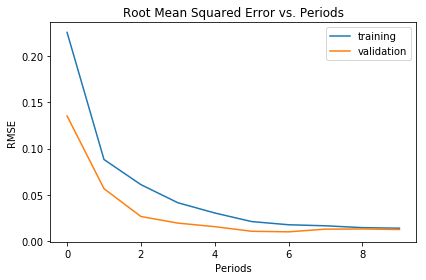

In [13]:
# Single neuron (may be better for predicting very short-term)
momentum_regressor_single_neuron, _, _ = train_nn_regression_model(
    optimizer=tf.train.MomentumOptimizer(learning_rate=0.0003, momentum=0.99, use_nesterov=True),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[1],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [14]:
# Select regressor to use
regressor = momentum_regressor_single_neuron

Stats on testing data:
  RMSE  : 0.030
  MAE   : 0.019
  MedAE : 0.017
  R^2   : 0.999


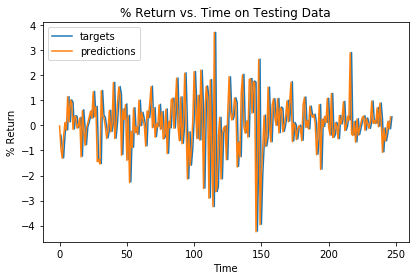

In [21]:
# Compute stats on testing set
predict_testing_input_fn = lambda: input_fn(testing_examples, np.zeros(testing_examples.shape), num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])

print("Stats on testing data:")

testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_targets, testing_predictions))
print("  RMSE  : %0.3f" % testing_root_mean_squared_error)

testing_mean_absolute_error = metrics.mean_absolute_error(testing_targets, testing_predictions)
print("  MAE   : %0.3f" % testing_mean_absolute_error)

testing_median_absolute_error = metrics.median_absolute_error(testing_targets, testing_predictions)
print("  MedAE : %0.3f" % testing_median_absolute_error)

testing_r2_score = metrics.r2_score(testing_targets, testing_predictions)
print("  R^2   : %0.3f" % testing_r2_score)

plt.ylabel("% Return")
plt.xlabel("Time")
plt.title("% Return vs. Time on Testing Data")
plt.tight_layout()
plt.plot(testing_targets, label="targets")
plt.plot(testing_predictions, label="predictions")
plt.legend()

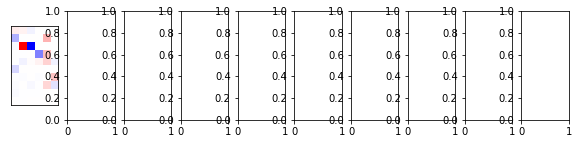

0                      open
1                      high
2                       low
3            adjusted_close
4                    volume
5                volume_adi
6                volume_obv
7               volume_obvm
8                volume_cmf
9                 volume_fi
10               volume_vpt
11               volume_nvi
12           volatility_atr
13           volatility_bbh
14           volatility_bbl
15           volatility_bbm
16          volatility_bbhi
17          volatility_bbli
18           volatility_kcc
19           volatility_kch
20           volatility_kcl
21          volatility_kcli
22           volatility_dch
23           volatility_dcl
24          volatility_dchi
25          volatility_dcli
26               trend_macd
27        trend_macd_signal
28          trend_macd_diff
29           trend_ema_fast
30           trend_ema_slow
31                trend_adx
32            trend_adx_pos
33            trend_adx_neg
34            trend_adx_ind
35     trend_vortex_

In [16]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Pad with 0s at end to make length 60
    padded = np.pad(coef, (0, 60 - coef.size), "constant", constant_values=0)
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.bwr, vmin=-0.5, vmax=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

display.display(pd.Series(training_examples.columns))

In [17]:
selected_features = training_examples.columns.values
latest_df = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, selected_features)
latest_features = preprocess_features(latest_df, feature_means, feature_stds).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)

predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = pd.Series([item["predictions"][0] for item in predictions])
display.display(predictions)

predictions_df = pd.DataFrame()
predictions_df["days_into_future"] = -predictions.index + prediction_period
predictions_df["close"] = latest_df["adjusted_close"].head(prediction_period) * (predictions/100.0 + 1.0)

print("Current predictions:")
display.display(predictions_df)

0   -0.023842
dtype: float64

Current predictions:


,days_into_future,close
0,1,181.06682
